In [1]:
# papermill parameters
zona = 31
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


In [2]:
# Parameters
zona = 55
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


### IMPORTA LAS LIBRERÍAS

In [3]:

import sys
import os

# Añadir la carpeta raíz del proyecto al sys.path
sys.path.append(os.path.abspath(".."))

import importlib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from scipy import stats
from shapely.geometry import Point



import src.utilidades as uti
import src.graficos as gra
import src.parametros_sismicos as par


importlib.reload(uti)
importlib.reload(par)
importlib.reload(gra)

<module 'src.graficos' from '/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM/src/graficos.py'>

### LECTURA DE DATAFRAME

In [4]:
# Leer el DataFrame guardado

filename = f"datos_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

gdf_in_out = pd.read_pickle(output_file)

gdf_in_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3574 entries, 20339 to 141401
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Evento        3574 non-null   object        
 1   Latitud       3574 non-null   float64       
 2   Longitud      3574 non-null   float64       
 3   Prof_Km       3574 non-null   float64       
 4   Inten         3574 non-null   object        
 5   Mag           3574 non-null   float64       
 6   Tipo_Mag      3574 non-null   Int64         
 7   Localizacion  3574 non-null   object        
 8   FechaHora     3574 non-null   datetime64[ns]
 9   Mag_mbLgL     3574 non-null   float64       
 10  geometry      3574 non-null   geometry      
 11  Zona_ID       3574 non-null   float64       
dtypes: Int64(1), datetime64[ns](1), float64(6), geometry(1), object(3)
memory usage: 366.5+ KB


### ANALISIS ESTADÍSTICO

In [5]:
# Número de eventos con magnitud < 1
n_menor_1 = gdf_in_out[gdf_in_out["Mag_mbLgL"] < 1].shape[0]

# Número total de eventos (sin NaN en magnitud)
n_total = gdf_in_out["Mag_mbLgL"].notna().sum()

# Proporción
proporcion = n_menor_1 / n_total

print("Número de eventos con magnitud < 1:", n_menor_1)
print("Número total de eventos:", n_total)
print(f"Proporción: {proporcion:.2%}")

Número de eventos con magnitud < 1: 253
Número total de eventos: 3574
Proporción: 7.08%


In [6]:

def analizar_magnitudes(df, col="Mag_mbLgL"):
    """
    Analiza estadísticamente una columna de magnitudes sísmicas.
    Devuelve un diccionario con estadísticas descriptivas, IQR, asimetría,
    curtosis y tests de normalidad.
    """
    # Convertir a numérico y quitar NaN
    #data = pd.to_numeric(df[col], errors="coerce").dropna()
    data=df[col]
    
    resultados = {}
    
    # === Estadísticas descriptivas básicas ===
    resultados["count"] = len(data)
    resultados["mean"] = data.mean()
    resultados["median"] = data.median()
    resultados["std"] = data.std()
    resultados["var"] = data.var()
    resultados["min"] = data.min()
    resultados["max"] = data.max()
    
    # === Rango intercuartílico (IQR) ===
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    resultados["Q1"] = Q1
    resultados["Q3"] = Q3
    resultados["IQR"] = IQR
    
    # === Forma de la distribución ===
    resultados["skewness"] = stats.skew(data)
    resultados["kurtosis"] = stats.kurtosis(data)
    
    # === Tests de normalidad ===
    shapiro_test = stats.shapiro(data.sample(min(5000, len(data))))  # límite 5000 obs
    resultados["Shapiro-Wilk p-value"] = shapiro_test.pvalue
    
    ks_norm_test = stats.kstest(data, "norm", args=(data.mean(), data.std()))
    resultados["Kolmogorov-Smirnov (normal) p-value"] = ks_norm_test.pvalue
    
    # === Test de ajuste a distribución exponencial ===
    loc, scale = stats.expon.fit(data)  # ajuste MLE
    ks_exp_test = stats.kstest(data, "expon", args=(loc, scale))
    resultados["Kolmogorov-Smirnov (exponencial) p-value"] = ks_exp_test.pvalue
    
    return resultados


In [7]:
res = analizar_magnitudes(gdf_in_out, "Mag_mbLgL")
display(res)

{'count': 3574,
 'mean': 1.624330181930486,
 'median': 1.6,
 'std': 0.5170382385910911,
 'var': 0.2673285401653781,
 'min': 0.1,
 'max': 5.279620853080568,
 'Q1': 1.3,
 'Q3': 1.9,
 'IQR': 0.5999999999999999,
 'skewness': 0.9553238592002269,
 'kurtosis': 3.2730005040377597,
 'Shapiro-Wilk p-value': 7.138657550768809e-33,
 'Kolmogorov-Smirnov (normal) p-value': 2.4180711890052263e-27,
 'Kolmogorov-Smirnov (exponencial) p-value': 0.0}

In [8]:

def analizar_distribucion(magnitudes, bins=30, output_file=None, zona=None):
    """
    Analiza la distribución de magnitudes:
    - Ajuste normal, exponencial, lognormal y Weibull
    - Histograma con curvas ajustadas
    - Ranking por p-value del KS test mostrado en un cuadro de texto
    """

    resultados = {}

    # === Ajuste Normal ===
    mu, sigma = stats.norm.fit(magnitudes)
    ks_stat, ks_p = stats.kstest(magnitudes, 'norm', args=(mu, sigma))
    resultados['Normal'] = {"mu": mu, "sigma": sigma, "KS p-value": ks_p}

    # === Ajuste Exponencial ===
    loc, scale = stats.expon.fit(magnitudes)
    ks_stat, ks_p = stats.kstest(magnitudes, 'expon', args=(loc, scale))
    resultados['Exponencial'] = {"loc": loc, "scale": scale, "KS p-value": ks_p}

    # === Ajuste Lognormal ===
    shape, loc, scale = stats.lognorm.fit(magnitudes, floc=0)
    ks_stat, ks_p = stats.kstest(magnitudes, 'lognorm', args=(shape, loc, scale))
    resultados['Lognormal'] = {"shape": shape, "loc": loc, "scale": scale, "KS p-value": ks_p}

    # === Ajuste Weibull ===
    c, loc, scale = stats.weibull_min.fit(magnitudes, floc=0)
    ks_stat, ks_p = stats.kstest(magnitudes, 'weibull_min', args=(c, loc, scale))
    resultados['Weibull'] = {"c": c, "loc": loc, "scale": scale, "KS p-value": ks_p}

    # === Gráfico ===
    x = np.linspace(min(magnitudes), max(magnitudes), 200)
    plt.figure(figsize=(10,6))
    plt.hist(
        magnitudes, bins=bins, density=True, alpha=0.5,
        color="skyblue", edgecolor="black", linewidth=0.5, label="Datos"
    )

    # Curvas ajustadas
    plt.plot(x, stats.norm.pdf(x, mu, sigma), "r-", lw=2, label="Normal")
    plt.plot(x, stats.expon.pdf(x, loc, scale), "g-", lw=2, label="Exponencial")
    plt.plot(x, stats.lognorm.pdf(x, shape, loc, scale), "b-", lw=2, label="Lognormal")
    plt.plot(x, stats.weibull_min.pdf(x, c, loc, scale), "m-", lw=2, label="Weibull")

    plt.xlabel("Magnitud", fontsize=14)
    plt.ylabel("Densidad", fontsize=14)
    plt.title(f"Ajuste de distribuciones a magnitudes (zona {zona})", fontsize=16)
    plt.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=10)

    # === Ranking por p-value ===
    ranking = sorted(resultados.items(), key=lambda x: x[1]["KS p-value"], reverse=True)

    # Construir el texto tipo tabla
    textstr = "Distribución       p-value\n"
    textstr += "-"*28 + "\n"
    for dist, vals in ranking:
        textstr += f"{dist:<15s} {vals['KS p-value']:.4e}\n"

    # Mostrar dentro de la gráfica
    plt.gca().text(
        0.65, 0.95, textstr, transform=plt.gca().transAxes,
        fontsize=10, verticalalignment="top", horizontalalignment="left",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8),
        family="monospace"  # 👈 Fuente monoespaciada para que quede tipo tabla
    )

    # Guardar en PNG y PDF
    #plt.savefig("terremotos_periodo.png", dpi=300, bbox_inches="tight")
    #plt.savefig("terremotos_periodo.pdf", bbox_inches="tight")

    # Guardar 
    if output_file:
        import os
        folder = os.path.dirname(output_file)
        if folder:
            os.makedirs(folder, exist_ok=True)
        plt.savefig(f"{output_file}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_file}.pdf", dpi=300, bbox_inches="tight")
        
    
    
    plt.show()

    return resultados



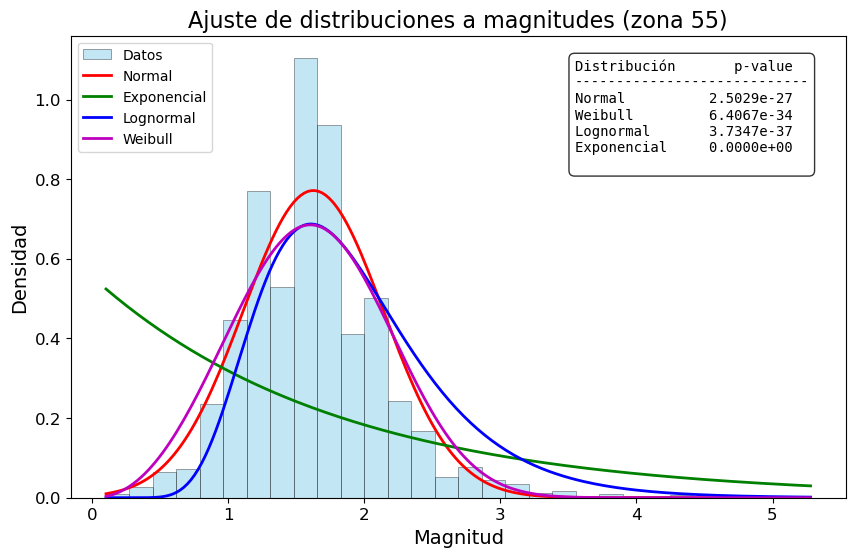

In [9]:

filename = f"/Ajuste_distribuciones_zona_{zona}"
output_file=ruta+"/figuras/"+filename

res = analizar_distribucion(gdf_in_out["Mag_mbLgL"],output_file=output_file,zona=zona)


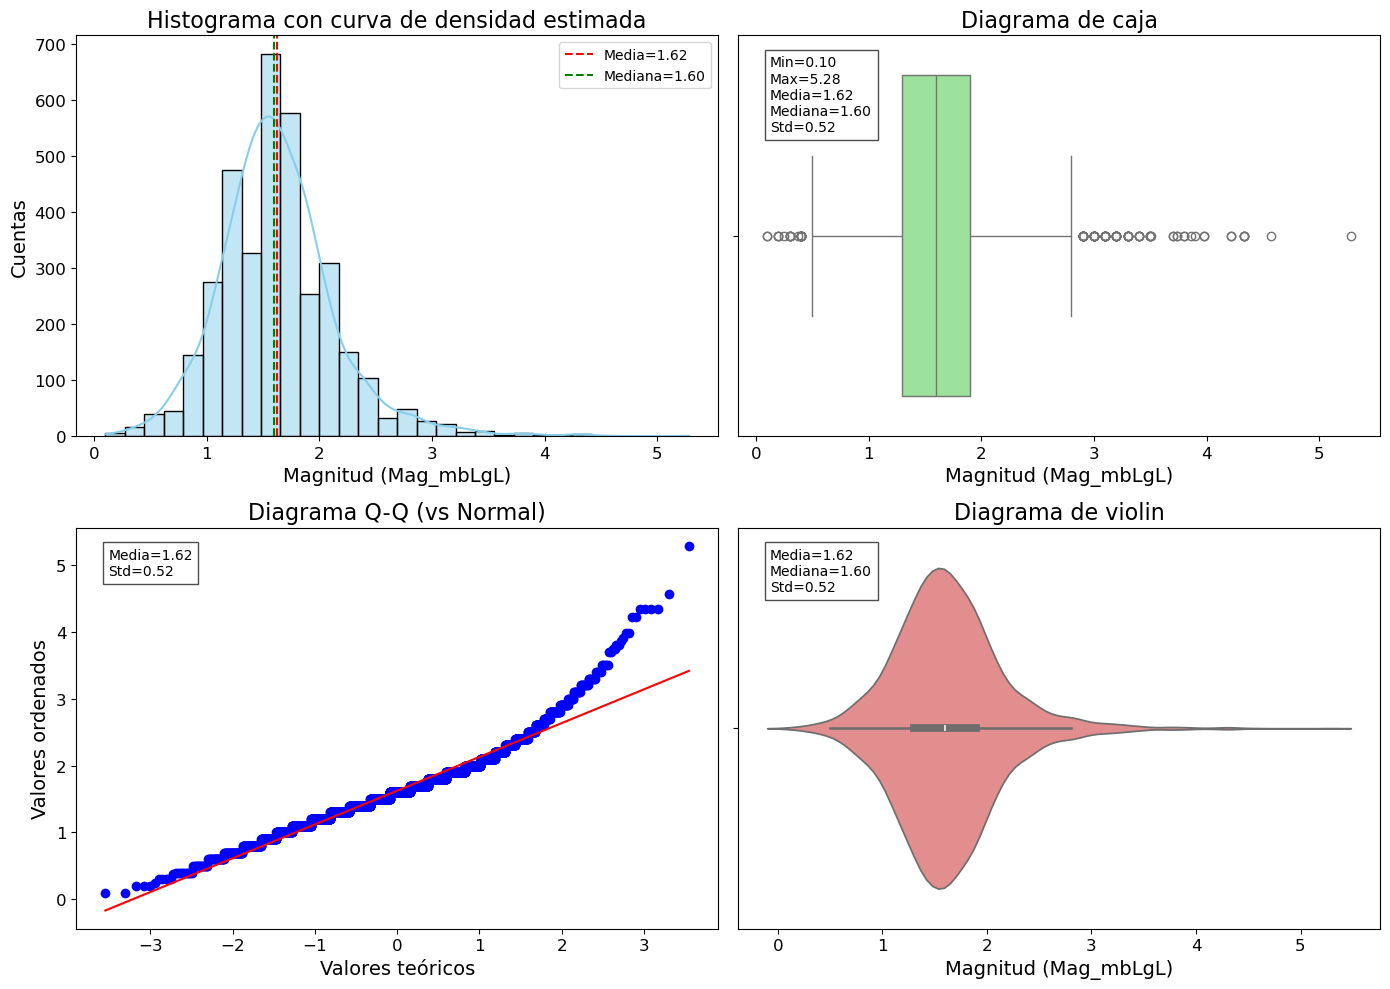

In [10]:
# Mostrar en pantalla
gra.graficos_magnitudes_mejorado(gdf_in_out, col_mag="Mag_mbLgL")


filename = f"estadisticos_eventos_zona_{zona}"
output_file=ruta+"/figuras/"+filename


# Guardar automáticamente PNG y PDF
gra.graficos_magnitudes_mejorado(gdf_in_out, col_mag="Mag_mbLgL", output_file=output_file)


### ANALISIS VISUAL

### Terremotos por año

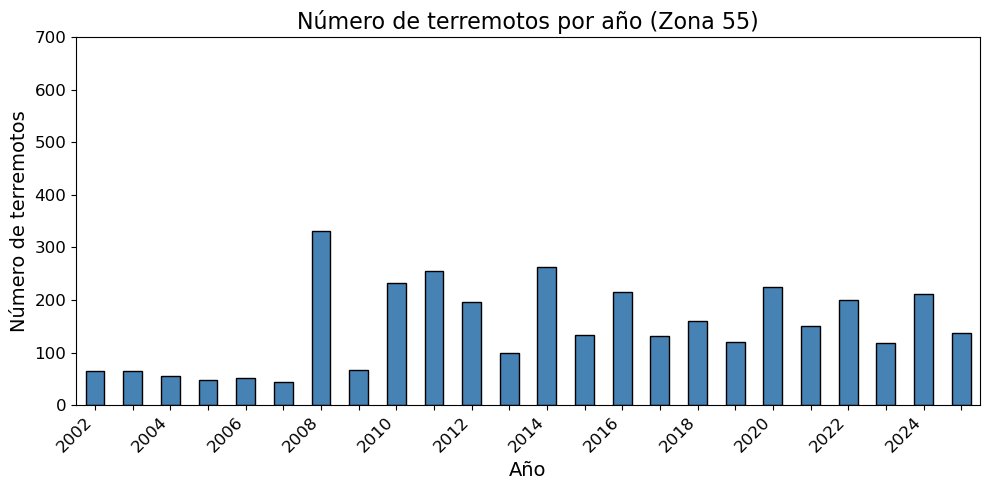

Gráficos guardados en: /Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM/figuras/terremotos_anuales_zona_55.png  y  /Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM/figuras/terremotos_anuales_zona_55.pdf


Año
2002     65
2003     65
2004     56
2005     47
2006     52
2007     44
2008    331
2009     66
2010    233
2011    255
2012    196
2013    100
2014    262
2015    133
2016    215
2017    131
2018    160
2019    120
2020    224
2021    150
2022    200
2023    119
2024    212
2025    138
dtype: int64

In [11]:
# Mostrar en pantalla
gra.plot_terremotos_por_anio(gdf_in_out,titulo=f"Número de terremotos por año (Zona {zona})")

ruta= "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"

# Guardar automáticamente PNG y PDF
#gra.plot_terremotos_por_anio_completo(gdf_in_out, output_base=ruta+f"/figuras/terremotos_anuales_zona_{zona}")

filename = f"terremotos_anuales_zona_{zona}"
output_file=ruta+"/figuras/"+filename

gra.plot_terremotos_por_anio(gdf_in_out,
                            fecha_col="FechaHora",
                            output_base=output_file,
                            include_all_years=True,
                            figsize=(10,5),
                            titulo=f"Número de terremotos por año (Zona {zona})"
)

### Distribución geométrica de terremotos

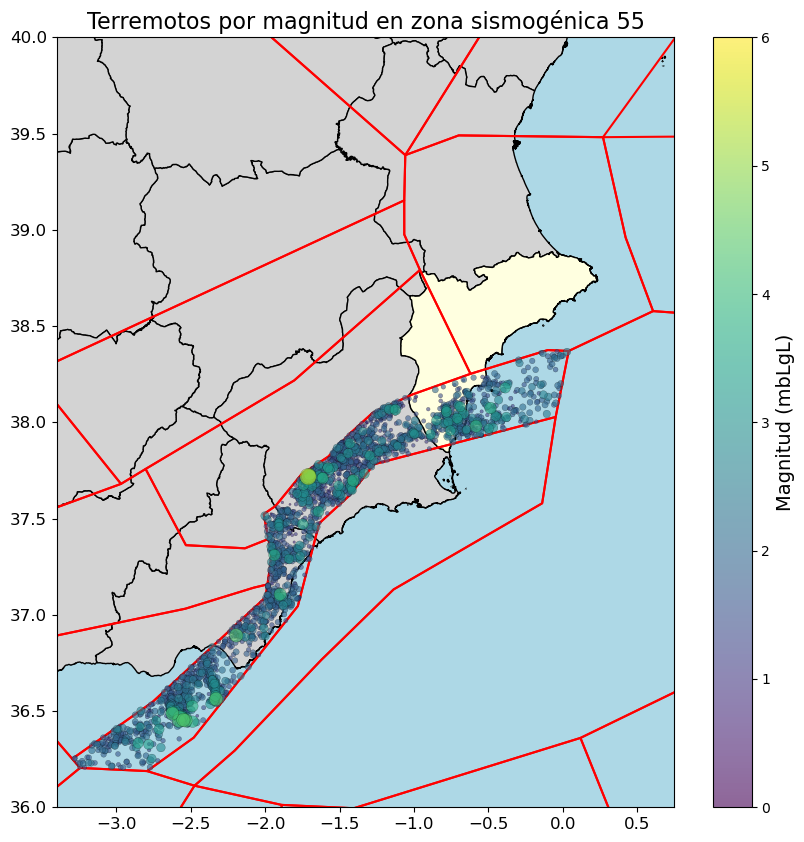

In [12]:

# === 2. Crear GeoDataFrame de epicentros ===
geometry = [Point(xy) for xy in zip(gdf_in_out["Longitud"], gdf_in_out["Latitud"])]
gdf_eq = gpd.GeoDataFrame(gdf_in_out, geometry=geometry, crs="EPSG:4326")

# === 3. Leer shapefile de zonas sismogénicas ===

filename = "ZESIS_20150421c.shp"
output_file=ruta+"/data/zonas/"+filename

zonas = gpd.read_file(output_file)
if zonas.crs != "EPSG:4326":
    zonas = zonas.to_crs("EPSG:4326")

# === 4. Leer shapefile de provincias ===

filename = "recintos_provinciales_inspire_peninbal_etrs89.shp"
output_file=ruta+"/data/mapa/"+filename

provincias = gpd.read_file(output_file)
if provincias.crs != "EPSG:4326":
    provincias = provincias.to_crs("EPSG:4326")

# === 5. Representación ===
fig, ax = plt.subplots(figsize=(10,10))

# Fondo azul claro = mar
ax.set_facecolor("lightblue")

# Provincias en gris claro
provincias.plot(ax=ax, color="lightgrey", edgecolor="black")

# Provincia de Alicante en otro color
provincias[provincias["NAMEUNIT"].str.contains("Alicante", case=False, na=False)].plot(
    ax=ax, color="lightyellow", edgecolor="black"
)

# Zonas sismogénicas: solo borde rojo más grueso
zonas.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.5)

# Ordenar de menor a mayor magnitud (para que los grandes se pinten al final)
gdf_eq2 = gdf_eq.sort_values("Mag")

# === 6. Epicentros con color + tamaño según magnitud ===
gdf_eq2["Mag"] = pd.to_numeric(gdf_eq2["Mag_mbLgL"], errors="coerce")
sizes = gdf_eq2["Mag"]**2 * 5   # tamaño relativo

sc = ax.scatter(
    gdf_eq2.geometry.x,
    gdf_eq2.geometry.y,
    c=gdf_eq2["Mag"],
    s=sizes,
    cmap="viridis",
    alpha=0.6,
    edgecolor="k",
    linewidth=0.2,
    vmin=0,      # mínimo fijo
    vmax=6     # máximo fijo
)

# Barra de color
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Magnitud (mbLgL)",fontsize=14)
cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])  # ticks fijos

# Límites del mapa
ax.set_xlim(-3.4, 0.75)    
ax.set_ylim(36, 40)        

plt.title(f"Terremotos por magnitud en zona sismogénica {zona}", fontsize=16)
plt.tick_params(axis='both', labelsize=12)

# Guardar automáticamente PNG y PDF
filename = f"terremotos_por_magnitud_zona_{zona}"
output_file=ruta+"/figuras/"+filename


# Guardar 
if output_file:
    import os
    folder = os.path.dirname(output_file)
    if folder:
        os.makedirs(folder, exist_ok=True)
    plt.savefig(f"{output_file}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{output_file}.pdf", dpi=300, bbox_inches="tight")
        

plt.show()


/var/folders/sw/ns8_83yx1sgg06xbf6tp3n640000gn/T/ipykernel_75879/918790791.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for periodo, grupo in gdf_eq.groupby("Periodo"):


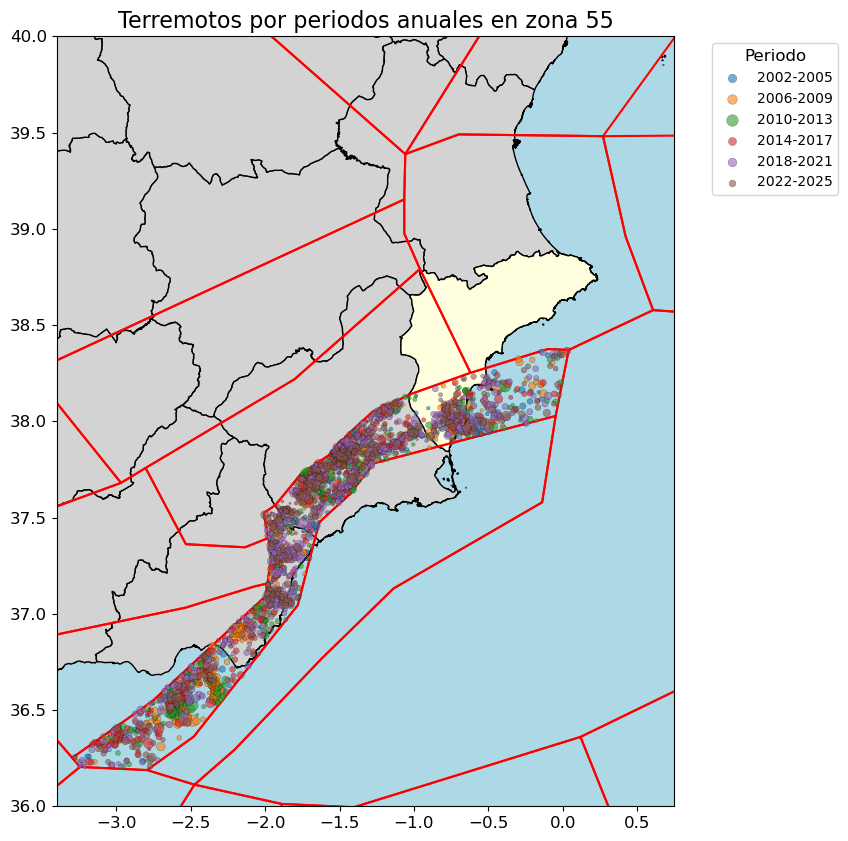

In [13]:

# === 2. Crear GeoDataFrame de epicentros ===
geometry = [Point(xy) for xy in zip(gdf_in_out["Longitud"], gdf_in_out["Latitud"])]
gdf_eq = gpd.GeoDataFrame(gdf_in_out, geometry=geometry, crs="EPSG:4326")

# Convertir magnitud a numérico
gdf_eq["Mag"] = pd.to_numeric(gdf_eq["Mag_mbLgL"], errors="coerce")

# Convertir fecha a datetime y extraer año
gdf_eq["Fecha"] = pd.to_datetime(gdf_eq["FechaHora"], errors="coerce", dayfirst=True)
gdf_eq["Año"] = gdf_eq["Fecha"].dt.year


# === Definir intervalos de 4 años, hasta 2026 para incluir 2022–2025 ===
bins = list(range(2002, 2026+4, 4))   # hasta 2029 para cubrir 2025
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
gdf_eq["Periodo"] = pd.cut(gdf_eq["Año"], bins=bins, labels=labels, include_lowest=True, ordered=True)

# Colores para cada intervalo
colors = dict(zip(labels, plt.cm.tab10.colors[:len(labels)]))  # paleta categórica

# === 4. Leer shapefiles ===

filename = "ZESIS_20150421c.shp"
output_file=ruta+"/data/zonas/"+filename

zonas = gpd.read_file(output_file)
if zonas.crs != "EPSG:4326":
    zonas = zonas.to_crs("EPSG:4326")

filename = "recintos_provinciales_inspire_peninbal_etrs89.shp"
output_file=ruta+"/data/mapa/"+filename

provincias = gpd.read_file(output_file)
if provincias.crs != "EPSG:4326":
    provincias = provincias.to_crs("EPSG:4326")

# === 5. Representación ===
fig, ax = plt.subplots(figsize=(10,10))

# Fondo azul claro = mar
ax.set_facecolor("lightblue")

# Provincias en gris claro
provincias.plot(ax=ax, color="lightgrey", edgecolor="black")

# Provincia de Alicante en otro color
provincias[provincias["NAMEUNIT"].str.contains("Alicante", case=False, na=False)].plot(
    ax=ax, color="lightyellow", edgecolor="black"
)

# Zonas sismogénicas: solo borde rojo más grueso
zonas.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.5)

# === 6. Epicentros ===
sizes = gdf_eq["Mag"]**2 * 5

for periodo, grupo in gdf_eq.groupby("Periodo"):
    if periodo in colors:  # evitar NaN
        ax.scatter(
            grupo.geometry.x,
            grupo.geometry.y,
            c=[colors[periodo]],
            s=sizes.loc[grupo.index],
            alpha=0.6,
            edgecolor="k",
            linewidth=0.2,
            label=periodo
        )

# Leyenda de intervalos
plt.legend(title="Periodo", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, title_fontsize=12)

# Límites del mapa
ax.set_xlim(-3.4, 0.75)    
ax.set_ylim(36, 40)        

plt.title(f"Terremotos por periodos anuales en zona {zona}", fontsize=16)
plt.tick_params(axis='both', labelsize=12)


# Guardar automáticamente PNG y PDF
filename = f"terremotos_por_periodo_zona_{zona}"
output_file=ruta+"/figuras/"+filename

# Guardar 
if output_file:
    import os
    folder = os.path.dirname(output_file)
    if folder:
        os.makedirs(folder, exist_ok=True)
    plt.savefig(f"{output_file}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{output_file}.pdf", dpi=300, bbox_inches="tight")
      

plt.show()


### Magnitud versus profundidad

In [14]:


def plot_dispersion_por_periodos(df, zona=None, ruta=None):
    """
    Representa magnitud vs profundidad coloreado por periodos de 4 años.
    
    Parámetros:
        df : DataFrame con columnas "Mag_mbLgL", "Prof_Km", "FechaHora"
        zona : str o None, nombre de la zona (para título y nombre de archivo)
        ruta : str o None, carpeta donde guardar las figuras (PNG y PDF)
    """
    df = df.copy()
    df["Año"] = df["FechaHora"].dt.year

    # === Definir intervalos de 4 años, hasta 2026 para incluir 2022–2025 ===
    bins = list(range(2002, 2026+4, 4))   # hasta 2029 para cubrir 2025
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
    df["Periodo"] = pd.cut(df["Año"], bins=bins, labels=labels, include_lowest=True, ordered=True)


    # === Gráfico ===
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x="Mag_mbLgL",
        y="Prof_Km",
        hue="Periodo",
        palette="viridis",
        alpha=0.7
    )

    # Límites de ejes
    plt.xlim(0, 6)
    plt.ylim(0, 85)
    plt.gca().invert_yaxis()

    # Estilo de ejes y títulos
    plt.title(f"Profundidad vs Magnitud {' - Zona '+str(zona) if zona else ''}", fontsize=16)
    plt.xlabel("Magnitud (mbLgL)", fontsize=14)
    plt.ylabel("Profundidad (Km)", fontsize=14)
    plt.tick_params(axis='both', labelsize=12)

    # Leyenda mejor colocada
    plt.legend(title="Periodo", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

    # Guardar si se indica ruta
    if ruta:
        import os
        folder = os.path.dirname(ruta)
        if folder:
            os.makedirs(folder, exist_ok=True)
        output_file = ruta + f"profundidad_magnitud_periodos{'_zona_'+str(zona) if zona else ''}"
        plt.savefig(f"{output_file}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_file}.pdf", dpi=300, bbox_inches="tight")

    plt.show()


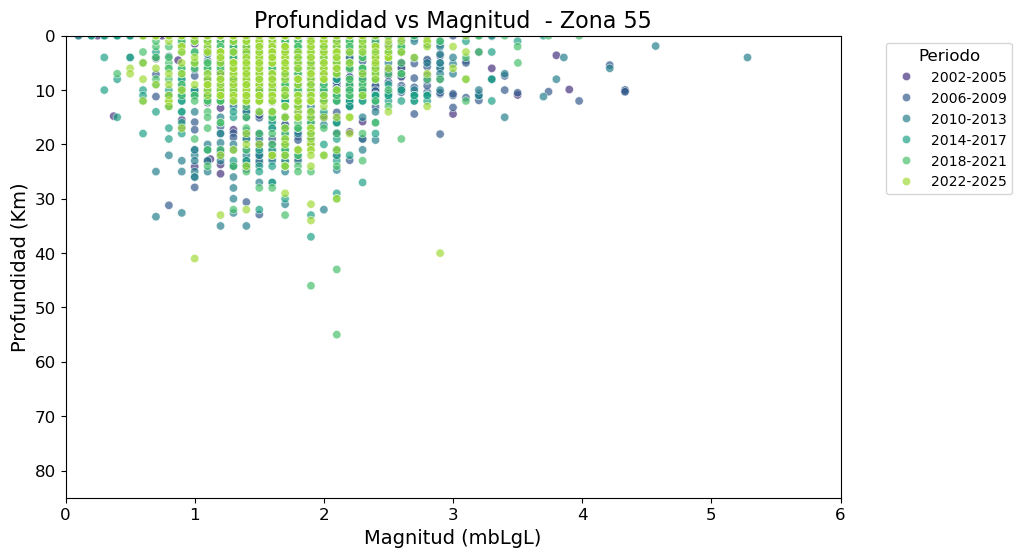

In [15]:

output_file=ruta+"/figuras/"

plot_dispersion_por_periodos(gdf_in_out, zona=zona, ruta=output_file)
